### SAFARI ANIMAL CLASSIFICATION
This project is about training a convolution neural network model that classifies images of animals you might find on a safari adventure.

### Exploring the data
The dataset was gotten from kaggle ad it contains the images of dogs, zebras, elephants and lion in the training and testing folder. I am using pytorch frame work to train the CNN classifier for them and the goal is to train a classifier with validation accuracy 0f at least 98% and above

4 classes:
['elephant', 'giraffe', 'lion', 'zebra']


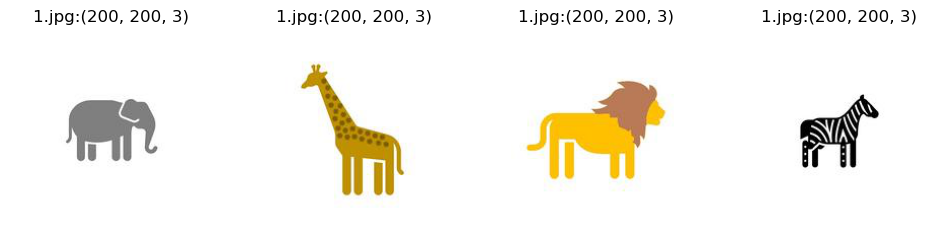

In [10]:
#import the libraries to be use
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#load the training dataset 
data_path = 'safari/training'

classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

#lets show the image, size and their respective classes
fig = plt.figure(figsize = (12,12))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path, sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    img_shape = np.array(img).shape
    a = fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file + ':' + str(img_shape))
plt.show()

You can see the image sample of the training dataset with their size and labels, the goal is to get 98% & above accuracy.

In [11]:
#import pytorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
print('Pytorch liberaries imported and ready ',torch.__version__)

Pytorch liberaries imported and ready  2.1.2+cpu


In [12]:
#lets create function to load our dataset i.e all the images from their respective folders
def upload_dataset(data_path):
    transformation = transforms.Compose([
        #transform to tensors
        transforms.ToTensor(),
        #lets normalize the pixels in RGB
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])
    
    #load and transform all the images & transform them
    total_dataset = torchvision.datasets.ImageFolder(
        root = data_path,
        transform = transformation)
    
#split dataset into training 70% and test 30
    train_size = int(0.7*len(total_dataset))
    test_size = len(total_dataset) - train_size
    X_train, X_test = torch.utils.data.random_split(total_dataset, [train_size, test_size])

#define a loader for training data
    train_loader = torch.utils.data.DataLoader(
    X_train,
    batch_size=50,
    num_workers=0,
    shuffle=False)
    
    test_loader = torch.utils.data.DataLoader(
    X_test,
    batch_size=50,
    num_workers=0,
    shuffle=False)
    return train_loader, test_loader

#get the iterative dataloaders
train_loader, test_loader = upload_dataset(data_path)
print('My data is uploaded successfully')

My data is uploaded successfully


In [13]:
#create a neural net class
class Net(nn.Module):
    def __init__(self, num_classes=4):
        super(Net,self).__init__()
        
        #input channels
        #our imagees are GB, so input channel is 3,we will apply 12 filters in the first convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        #we will apply max pooling with kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        #A second convolutional layer takes 12 inputs channels, ang genarates 12 output
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
       
        # A third convolutional layer takes 12 inputs and generates 24 outputs channels
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout(p=0.2)
        
        #Our 200x200 image tensors will be pooled twice with a kernel size of 2, 200/2/2 is 50.
        #So our feature tensors are now 50 X 50, and we have generated 24 of them
        #we need to flatten these and feed them to a fully-connected layer 
        #to map them to probability of each class
        self.fc = nn.Linear(in_features=50*50*24, out_features=num_classes)
        
        
    def forward(self,x):
        x = F.relu(self.pool(self.conv1(x)))
        #use a relu activation function after layer 1 (convolution 1 & pool)
        
        x = F.relu(self.pool(self.conv2(x)))
        # use a relu activation function after layer 2 (convolution 2 & pool)
            
        x = F.relu(self.drop(self.conv3(x)))
        # select some features to drop after 3rd convolution to prevent overfitting
            
        x = F.dropout(x, training=self.training)
        # only drop the features if this is a training pass
        
        #flatten
        x = x.view(-1, 50*50*24)
        # feed to fully-connected layer to predict the class
        
        x = self.fc(x)
        return F.log_softmax(x,dim=1)
        # return log_softmax tensor
print('The CNN MODEL CLASS is ready')

The CNN MODEL CLASS is ready


### Train the model

In [14]:
# Define a function that train the model and aswell test the model
def train(model, device, train_loader, optimizer,epoch):
    #set the model to training mode
    model.train()
    train_loss = 0
    print('Epoch:', epoch)
    #process the images in batches
    for batch_idx, (data,target) in enumerate(train_loader):
        #use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        #reset the optimzer
        optimizer.zero_grad()
        
        #push the data forward through the model layers
        output = model(data)
        
        #get the loss
        loss = loss_criteria(output, target)
        
        #keep a running total
        train_loss += loss.item()
        
        #backpropagate
        loss.backward()
        optimizer.step()
        #print metrics for every 10 batches so as to see the progress
        if batch_idx % 10 ==0:
            print('Training sef[{}/{}({:.0f}%)] loss: {:.6f}'.format(
            batch_idx*len(data), len(train_loader.dataset),
            100. * batch_idx/len(train_loader), loss.item()))
    #return average loss for the epoch        
    avg_loss = train_loss/ (batch_idx+1)
    print('training set: average loss: {:.6f}'.format(avg_loss))
    return avg_loss



def test(model, device, test_loader):
    #switch the model to evaluation(so we dont back propergate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            #get the predicted classes for this batch
            output = model(data)
            
            #calculate the accuracy for this batch
            test_loss += loss_criteria(output, target).item()
            
            _, predicted = torch.max(output.data,1)
            correct += torch.sum(target==predicted).item()
            
            #Calculate avg loss and total accuracy for this epcoh
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    #return average loss for the epoch
    return avg_loss


# let use the train & test functions to train & test the model

device = 'cpu'
if (torch.cuda.is_available()):
    #if GPU available, use cuda (training on cpu will take a considerable length of time)
    device = 'cuda'
print('training on', device)

#create an instance of the model class and allocate it to the device
model =Net(num_classes=len(classes)).to(device)

#use an Adam optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

#specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

#Track the metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

#train over 10 epoch
epochs = 10
for epoch in range(1, epochs +1):
    train_loss = train(model, device, train_loader,optimizer, epoch)
    test_loss = test(model, device, test_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


training on cpu
Epoch: 1
Training sef[0/277(0%)] loss: 1.393046
training set: average loss: 1.319539
Validation set: Average loss: 0.730086, Accuracy: 92/119 (77%)

Epoch: 2
Training sef[0/277(0%)] loss: 0.584433
training set: average loss: 0.372156
Validation set: Average loss: 0.156506, Accuracy: 119/119 (100%)

Epoch: 3
Training sef[0/277(0%)] loss: 0.082735
training set: average loss: 0.056164
Validation set: Average loss: 0.013389, Accuracy: 119/119 (100%)

Epoch: 4
Training sef[0/277(0%)] loss: 0.012752
training set: average loss: 0.006296
Validation set: Average loss: 0.003318, Accuracy: 119/119 (100%)

Epoch: 5
Training sef[0/277(0%)] loss: 0.001972
training set: average loss: 0.000987
Validation set: Average loss: 0.000295, Accuracy: 119/119 (100%)

Epoch: 6
Training sef[0/277(0%)] loss: 0.000167
training set: average loss: 0.000267
Validation set: Average loss: 0.000246, Accuracy: 119/119 (100%)

Epoch: 7
Training sef[0/277(0%)] loss: 0.000379
training set: average loss: 0.00

### View the loss history
check for overfitting and underfitting

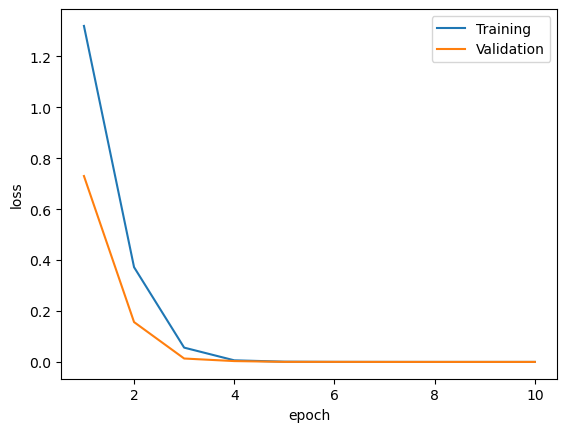

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.show()

### Evaluate model performance using  confusion matrix

get prediction from test set


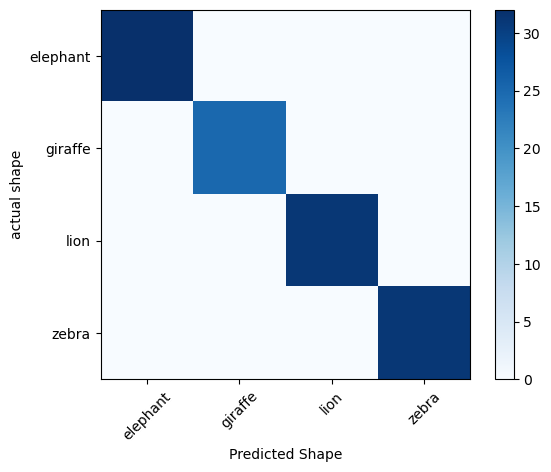

In [16]:
from sklearn.metrics import confusion_matrix

model.eval()

#get predictions for the test data
print('get prediction from test set')
truelabels = []
predictions = []
for data, target in test_loader:
    for label  in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction)
        
#plot the cm
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation = 'nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Shape')
plt.ylabel('actual shape')
plt.show()

### Save the model
add code below to save the model's weights

In [17]:
#save the model weights
saved_model = 'safari_animal_classifier.pt'
torch.save(model.state_dict(), saved_model)
del model
print('model saved as', saved_model)

model saved as safari_animal_classifier.pt


### Use the trained model
Now the trained model is ready, lets make a predictions

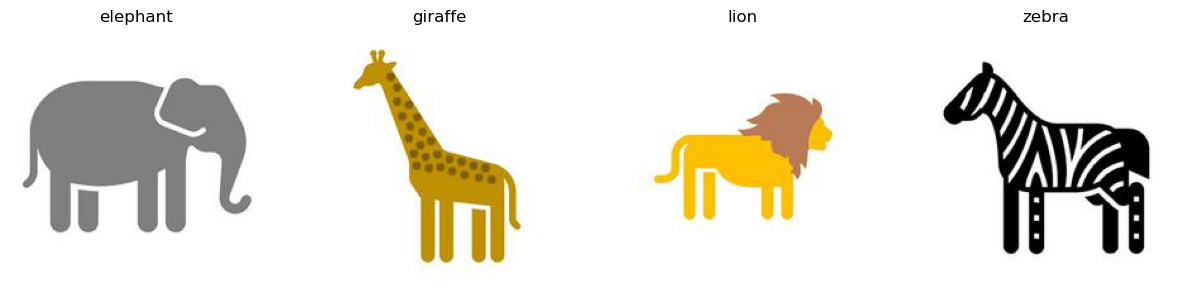

In [18]:
import os
from random import randint
%matplotlib inline

# Function to predict the class of an image
def predict_image(classifier, image):
    import numpy
    
    # Default value
    index = 0
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Load your model
model = Net()
model.load_state_dict(torch.load(saved_model))

# The images are in the data/shapes folder
test_data_path = 'safari/test'

# Show the test images with predictions
fig = plt.figure(figsize=(15, 12))
i = 0
for img_file in os.listdir(test_data_path):
    i+=1
    img_path = os.path.join(test_data_path, img_file)
    img = mpimg.imread(img_path)
    # Get the image class prediction
    index = predict_image(model, np.array(img))
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(classes[index])
plt.show()

The mdoel predicted all the four classes correctly.